# Reducing depth of circuits with operator backpropagation

Operator backpropagation is a technique which involves absorbing operations from the end of a quantum circuit into a Pauli operator, generally reducing the depth of the circuit at the cost of additional terms in the operator. The goal is to backpropagate as much of the circuit as possible without allowing the operator to grow too large.

One way to allow for deeper backpropagation into the circuit, while preventing the operator from growing too large, is to truncate terms with small coefficients, rather than adding them to the operator. Truncating terms can result in fewer quantum circuits to execute, but doing so results in some error in the final expectation value calculation proportional to the magnitude of the truncated terms' coefficients.

In this tutorial we will implement a [Qiskit pattern](https://quantum.cloud.ibm.com/docs/guides/serverless#qiskit-patterns-with-quantum-serverless) for simulating the quantum dynamics of a Heisenberg spin chain using operator backpropagation:

- **Step 1: Map to quantum problem**
    - Map the time-evolved Hamiltonian onto a quantum circuit
- **Step 2: Optimize the problem**
    - Slice the circuit
    - <font color="#0F62FE">Backpropagate slices from the circuit onto a Pauli observable</font>
    - Combine the remaining slices into a single circuit
    - Transpile the circuit for the backend
- **Step 3: Execute experiments**
    - Calculate the expectation value using the reduced circuit and expanded observable with a [StatevectorEstimator](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.primitives.StatevectorEstimator) for sake of simplicity in this notebook
- **Step 4: Reconstruct results**
    - N.A.

**Note:** Qiskit loosely describes [layers](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.dagcircuit.DAGCircuit) as being depth-1 partitions of the circuit across all qubits. This package makes use of the term **slices** to describe layers of arbitrary depth. The [qiskit_addon_obp.backpropagate](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.backpropagate.html) function is designed to backpropagate entire slices at a time, so the choice of how to slice the quantum circuit can have a major impact on how well backpropagation performs for a given problem. You will lean more about **slices** below.

## Step 1: Map to quantum problem
### Map the time-evolution of a quantum Heisenberg model to a quantum experiment.

The [qiskit_addon_utils](https://qiskit.github.io/qiskit-addon-utils/) package provides some reusable functionalities for various purposes.

Its [qiskit_addon_utils.problem_generators](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.problem_generators.html) module provides functions to generate Heisenberg-like Hamiltonians on a given connectivity graph.
This graph can be either a [rustworkx.PyGraph](https://www.rustworkx.org/apiref/rustworkx.PyGraph.html) or a [CouplingMap](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.transpiler.CouplingMap) making it easy to use in Qiskit-centric workflows.

In the following, we first generate a heavy-hex `CouplingMap` out of which we carve a linear chain of 10 qubits. Note, that the indices of this new `reduced_coupling_map` are again zero-based.

In [1]:
from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce([0, 13, 1, 14, 10, 16, 5, 12, 8, 18])

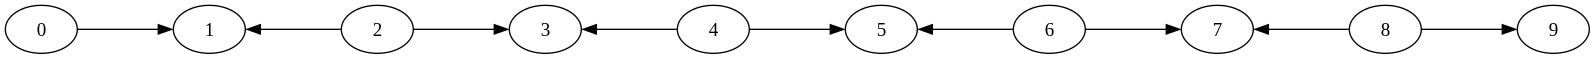

In [2]:
from rustworkx.visualization import graphviz_draw

graphviz_draw(reduced_coupling_map.graph, method="circo")

Next, we generate a Pauli operator modeling a Heisenberg XYZ Hamiltonian.

$$\hat{H} = \sum_{(j,k)\in E} (J_{x} \sigma_j^{x} \sigma_{k}^{x} +
    J_{y} \sigma_j^{y} \sigma_{k}^{y} + J_{z} \sigma_j^{z} \sigma_{k}^{z}) +
    \sum_{j\in V} (h_{x} \sigma_j^{x} + h_{y} \sigma_j^{y} + h_{z} \sigma_j^{z})$$

Where $G(V,E)$ is the graph of the coupling map provided.

In [3]:
import numpy as np
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)
print(hamiltonian)

SparsePauliOp(['IIIIIIIXXI', 'IIIIIIIYYI', 'IIIIIIIZZI', 'IIIIIXXIII', 'IIIIIYYIII', 'IIIIIZZIII', 'IIIXXIIIII', 'IIIYYIIIII', 'IIIZZIIIII', 'IXXIIIIIII', 'IYYIIIIIII', 'IZZIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ', 'IIIIIIXXII', 'IIIIIIYYII', 'IIIIIIZZII', 'IIIIXXIIII', 'IIIIYYIIII', 'IIIIZZIIII', 'IIXXIIIIII', 'IIYYIIIIII', 'IIZZIIIIII', 'XXIIIIIIII', 'YYIIIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIIY', 'IIIIIIIIIZ', 'IIIIIIIIXI', 'IIIIIIIIYI', 'IIIIIIIIZI', 'IIIIIIIXII', 'IIIIIIIYII', 'IIIIIIIZII', 'IIIIIIXIII', 'IIIIIIYIII', 'IIIIIIZIII', 'IIIIIXIIII', 'IIIIIYIIII', 'IIIIIZIIII', 'IIIIXIIIII', 'IIIIYIIIII', 'IIIIZIIIII', 'IIIXIIIIII', 'IIIYIIIIII', 'IIIZIIIIII', 'IIXIIIIIII', 'IIYIIIIIII', 'IIZIIIIIII', 'IXIIIIIIII', 'IYIIIIIIII', 'IZIIIIIIII', 'XIIIIIIIII', 'YIIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.39269908+0.j, 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j,
 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j, 0.78539816+0.j,
 1.57079633+0.j, 0.39269908+0.j, 0.

From the qubit operator, we can generate a quantum circuit which models its time evolution.
Once again, the [qiskit_addon_utils.problem_generators](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.problem_generators.html) module comes to the resuce with a handy function do just that:

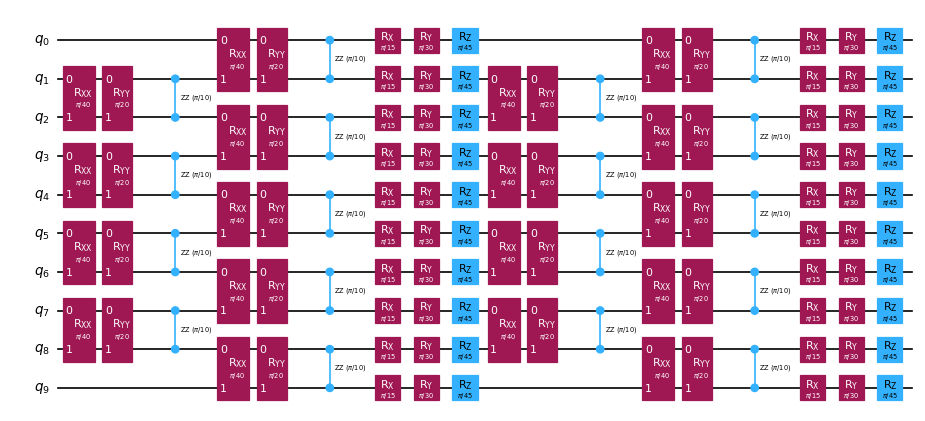

In [4]:
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

circuit = generate_time_evolution_circuit(
    hamiltonian,
    time=0.2,
    synthesis=LieTrotter(reps=2),
)
circuit.draw("mpl", style="iqp", scale=0.6)

## Step 2: Optimize the problem
### Create circuit slices to backpropagate

Remember, the ``backpropagate`` function will backpropagate entire circuit slices at a time, so the choice of how to slice can have an impact on how well backpropagation performs for a given problem. Here, we will group gates of the same type into slices using the [slice_by_gate_types](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.slicing.slice_by_gate_types.html) function.

For a more detailed discussion on circuit slicing, check out this [how-to guide](https://qiskit.github.io/qiskit-addon-utils/how_tos/create_circuit_slices.html) of the [qiskit-addon-utils](https://qiskit.github.io/qiskit-addon-utils/index.html) package.

In [5]:
from qiskit_addon_utils.slicing import slice_by_gate_types

slices = slice_by_gate_types(circuit)
print(f"Separated the circuit into {len(slices)} slices.")

Separated the circuit into 18 slices.


### Constrain how large the operator may grow during backpropagation

During backpropagation, the number of terms in the operator will generally approach $4^N$ quickly, where $N$ is the number of qubits. The size of the operator can be bounded by specifying the ``operator_budget`` kwarg of the ``backpropagate`` function, which accepts an [OperatorBudget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.simplify.OperatorBudget.html) instance.

Here we specify that backpropagation should stop when the number of qubit-wise commuting Pauli groups in the operator grows past 8.

In [6]:
from qiskit_addon_obp.utils.simplify import OperatorBudget

op_budget = OperatorBudget(max_qwc_groups=8)

### Backpropagate slices from the circuit

First, we will specify the Pauli-Z observable on qubit 0, and we will backpropagate slices from the time-evolution circuit until the terms in the observable can no longer be combined into 8 or fewer qubit-wise commuting Pauli groups.

Below you will see that we backpropagated 7 slices but only used 6 of the 8 allotted Pauli groups. This implies that backpropagating one more slice would cause the number of Pauli groups to exceed 8. We can verify that this is the case by inspecting the returned metadata.

Backpropagated 7 slices.
New observable has 18 terms, which can be combined into 8 groups.
Note that backpropagating one more slice would result in 27 terms across 12 groups.
The remaining circuit after backpropagation looks as follows:


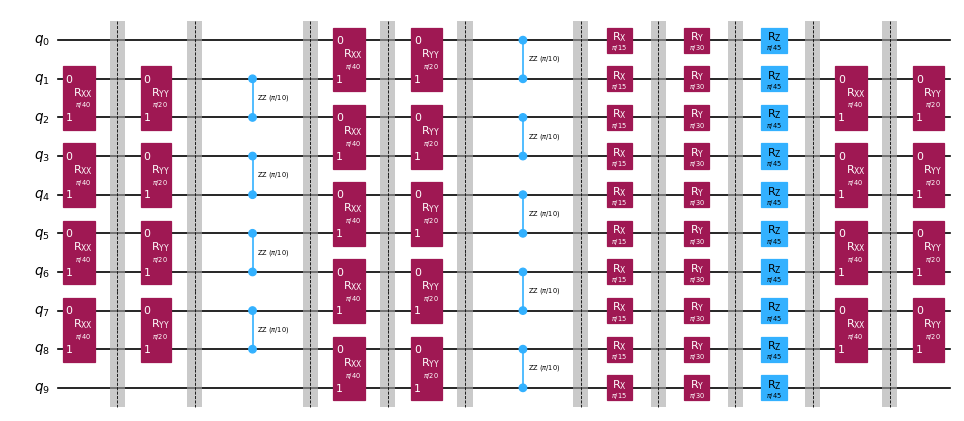

In [7]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices

# Specify a single-qubit observable
observable = SparsePauliOp("IIIIIIIIIZ")

# Backpropagate slices onto the observable
bp_obs, remaining_slices, metadata = backpropagate(observable, slices, operator_budget=op_budget)
# Recombine the slices remaining after backpropagation
bp_circuit = combine_slices(remaining_slices, include_barriers=True)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(bp_obs.paulis)} terms, which can be combined into {len(bp_obs.group_commuting(qubit_wise=True))} groups."
)
print(
    f"Note that backpropagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups."
)
print("The remaining circuit after backpropagation looks as follows:")
bp_circuit.draw("mpl", scale=0.6)

Next, we will specify the same problem with the same constraints on the size of the output observable. However, this time, we allot an error budget to each slice using the [setup_budet](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.setup_budget.html) function. Pauli terms with small coefficients will be truncated from each slice until the error budget is filled, and leftover budget will be added to the following slice's budget.

In order to enable this truncation, we need to setup our error budget like so:

In [8]:
from qiskit_addon_obp.utils.truncating import setup_budget

truncation_error_budget = setup_budget(max_error_per_slice=0.005)

Note that by allocating `5e-3` error per slice for truncation, we are able to remove 3 more slices from the circuit, while remaining within the original budget of 8 commuting Pauli groups in the observable. By default, `backpropagate` uses the L1 norm of the truncated coefficients to bound the total error incurred from truncation. For other options refer to the [how-to guide on specifying the p_norm](https://qiskit.github.io/qiskit-addon-obp/how_tos/bound_error_using_p_norm.html).

In this particular example where we have backpropagated 10 slices, the total truncation error should not exceed ``(5e-3 error/slice) * (10 slices) = 5e-2``.
For further discussion on distributing an error budget across your slices, check out [this how-to guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html).

Backpropagated 10 slices.
New observable has 19 terms, which can be combined into 8 groups.
After truncation, the error in our observable is bounded by 4.933e-02
Note that backpropagating one more slice would result in 27 terms across 13 groups.
The remaining circuit after backpropagation looks as follows:


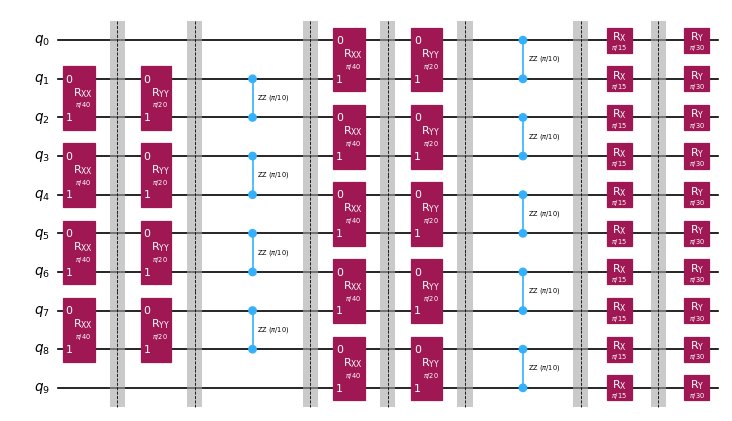

In [9]:
# Run the same experiment but truncate observable terms with small coefficients
bp_obs_trunc, remaining_slices_trunc, metadata = backpropagate(
    observable, slices, operator_budget=op_budget, truncation_error_budget=truncation_error_budget
)

# Recombine the slices remaining after backpropagation
bp_circuit_trunc = combine_slices(remaining_slices_trunc, include_barriers=True)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(bp_obs_trunc.paulis)} terms, which can be combined into {len(bp_obs_trunc.group_commuting(qubit_wise=True))} groups.\n"
    f"After truncation, the error in our observable is bounded by {metadata.accumulated_error(0):.3e}"
)
print(
    f"Note that backpropagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups."
)
print("The remaining circuit after backpropagation looks as follows:")
bp_circuit_trunc.draw("mpl", scale=0.6)

### Now that we have our reduced ansatze and expanded observables, we can transpile our experiments to the backend.

Here we will use the 14-qubit [FakeMelbourneV2](https://quantum.cloud.ibm.com/docs/api/qiskit-ibm-runtime/fake-provider-fake-melbourne-v2) from [qiskit-ibm-runtime](https://quantum.cloud.ibm.com/docs/api/qiskit-ibm-runtime) to demonstrate how to transpile to a QPU backend.

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2

# Specify a backend and a pass manager for transpilation
backend = FakeMelbourneV2()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

# Transpile original experiment
circuit_isa = pm.run(circuit)
observable_isa = observable.apply_layout(circuit_isa.layout)

# Transpile backpropagated experiment
bp_circuit_isa = pm.run(bp_circuit)
bp_obs_isa = bp_obs.apply_layout(bp_circuit_isa.layout)

# Transpile the backpropagated experiment with truncated observable terms
bp_circuit_trunc_isa = pm.run(bp_circuit_trunc)
bp_obs_trunc_isa = bp_obs_trunc.apply_layout(bp_circuit_trunc_isa.layout)

## Step 3: Execute quantum experiments
### Calculate expectation value

Finally, we can run the backpropagated experiments and compare them with the full experiment using the noiseless [StatevectorEstimator](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.primitives.StatevectorEstimator). We can see that the backpropagated expectation value without truncation is equivalent to the exact value within the limits of numerical precision.

The expectation value on the operator with truncated terms has some error on the order of ``1e-4``, which is within the expected tolerance.

**Note:** We use a statevector-based ``Estimator`` primitive to illustrate the effect of truncation on the output. To run on the backend to which the experiments were transpiled in Step 2, one would import the [EstimatorV2](https://quantum.cloud.ibm.com/docs/api/qiskit-ibm-runtime/estimator-v2) from ``qiskit-ibm-runtime`` and pass the backend instance into the constructor.

In [11]:
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()

# Run the experiments using Estimator primitive
result_exact = estimator.run([(circuit_isa, observable_isa)]).result()[0].data.evs.item()
result_bp = estimator.run([(bp_circuit_isa, bp_obs_isa)]).result()[0].data.evs.item()
result_bp_trunc = (
    estimator.run([(bp_circuit_trunc_isa, bp_obs_trunc_isa)]).result()[0].data.evs.item()
)

print(f"Exact expectation value: {result_exact}")
print(f"Backpropagated expectation value: {result_bp}")
print(f"Backpropagated expectation value with truncation: {result_bp_trunc}")
print(f"    - Expected Error for truncated observable: {metadata.accumulated_error(0):.3e}")
print(f"    - Observed Error for truncated observable: {abs(result_exact - result_bp_trunc):.3e}")

Exact expectation value: 0.8854160687717507
Backpropagated expectation value: 0.8854160687717532
Backpropagated expectation value with truncation: 0.8850236647156059
    - Expected Error for truncated observable: 4.933e-02
    - Observed Error for truncated observable: 3.924e-04
